In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# image_path = "/home/spidermines/UCR/Q3/ACV/Assignment-1/TEST_IMAGES/lena_gray_256_noisy.png"
image_path = "/content/drive/MyDrive/ACV/Assignment-1/TEST_IMAGES/lena_gray_256_noisy.png"

In [ ]:
noisy_img = plt.imread(image_path)

noisy_img = torch.tensor(noisy_img, dtype=torch.float32)

In [ ]:
noisy_img.shape

torch.Size([256, 256])

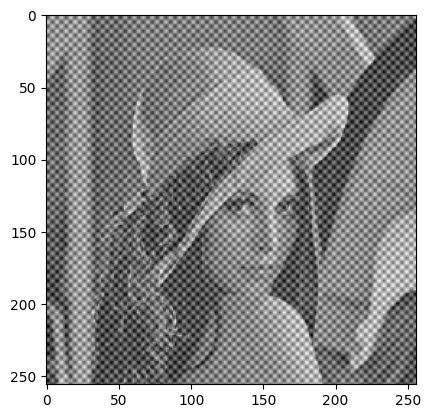

In [ ]:
plt.imshow(noisy_img, cmap="gray")

In [ ]:
def construct_laplacian_pyramid(image, levels, sigma):
    pyramid = [image]
    for _ in range(1, levels):
        height, width = image.shape[-2:]
        # print(f"Original image shape: {height} x {width}")
        # print(f"Original image tensor shape: {image.shape}")
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        blurred = TF.resize(image, (height, width), interpolation=TF.InterpolationMode.BILINEAR)
        blurred = blurred.squeeze(0).squeeze(0)  # Remove batch and channel dimensions
        # print(f"Blurred image shape: {blurred.shape[-2]} x {blurred.shape[-1]}")
        expanded = TF.resize(blurred, (height, width), interpolation=TF.InterpolationMode.BILINEAR)
        # expanded = TF.resize(blurred, (height*2, width*2), interpolation=TF.InterpolationMode.BILINEAR)
        # print(f"Expanded image shape: {expanded.shape[-2]} x {expanded.shape[-1]}")
        difference = image - expanded
        pyramid.append(difference)
        image = blurred
    pyramid.append(image)
    return pyramid[::-1]


In [ ]:
# Generates a 1D Gaussian kernel.
def gaussian_kernel(size, sigma):
    x = torch.arange(size, dtype=torch.float32)
    kernel = torch.exp(-0.5 * ((x - size // 2) / sigma) ** 2)
    kernel = kernel / kernel.sum()
    return kernel

In [ ]:
# Function to apply Gaussian filter
def gaussian_filter(image, sigma):
    kernel_size = int(4 * sigma + 1)
    sigma_tensor = torch.tensor(sigma)  # Convert sigma to a tensor
    kernel = torch.tensor([torch.exp(-(x - kernel_size // 2) ** 2 / (2 * sigma_tensor ** 2)) for x in range(kernel_size)])
    kernel = kernel / kernel.sum()
    kernel = kernel.unsqueeze(0).unsqueeze(0)

    # Add batch and channel dimensions if missing
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)

    # Apply convolution
    image = torch.nn.functional.conv2d(image, kernel.unsqueeze(0), padding=kernel_size // 2)
    return image.squeeze(0).squeeze(0)


In [ ]:
# Function to denoise image using Laplacian pyramid
def denoise_laplacian_pyramid(noisy_img, levels, sigma):
    # Construct Laplacian pyramid
    laplacian_pyramid = construct_laplacian_pyramid(noisy_img, levels, sigma)

    # Apply Gaussian filter to each level of the Laplacian pyramid
    for i in range(levels):
        laplacian_pyramid[i] = gaussian_filter(laplacian_pyramid[i], sigma)

    # Reconstruct the denoised image from the Laplacian pyramid
    denoised_img = laplacian_pyramid[0]
    for i in range(1, levels):
        denoised_img = denoised_img + laplacian_pyramid[i]
    return denoised_img


In [ ]:
# denoised_img = denoise_gaussian_pyramid(noisy_img, levels=2, sigma=1)

In [ ]:
sigma_values = [2, 2.5, 3]
level_values = [2, 3, 4]

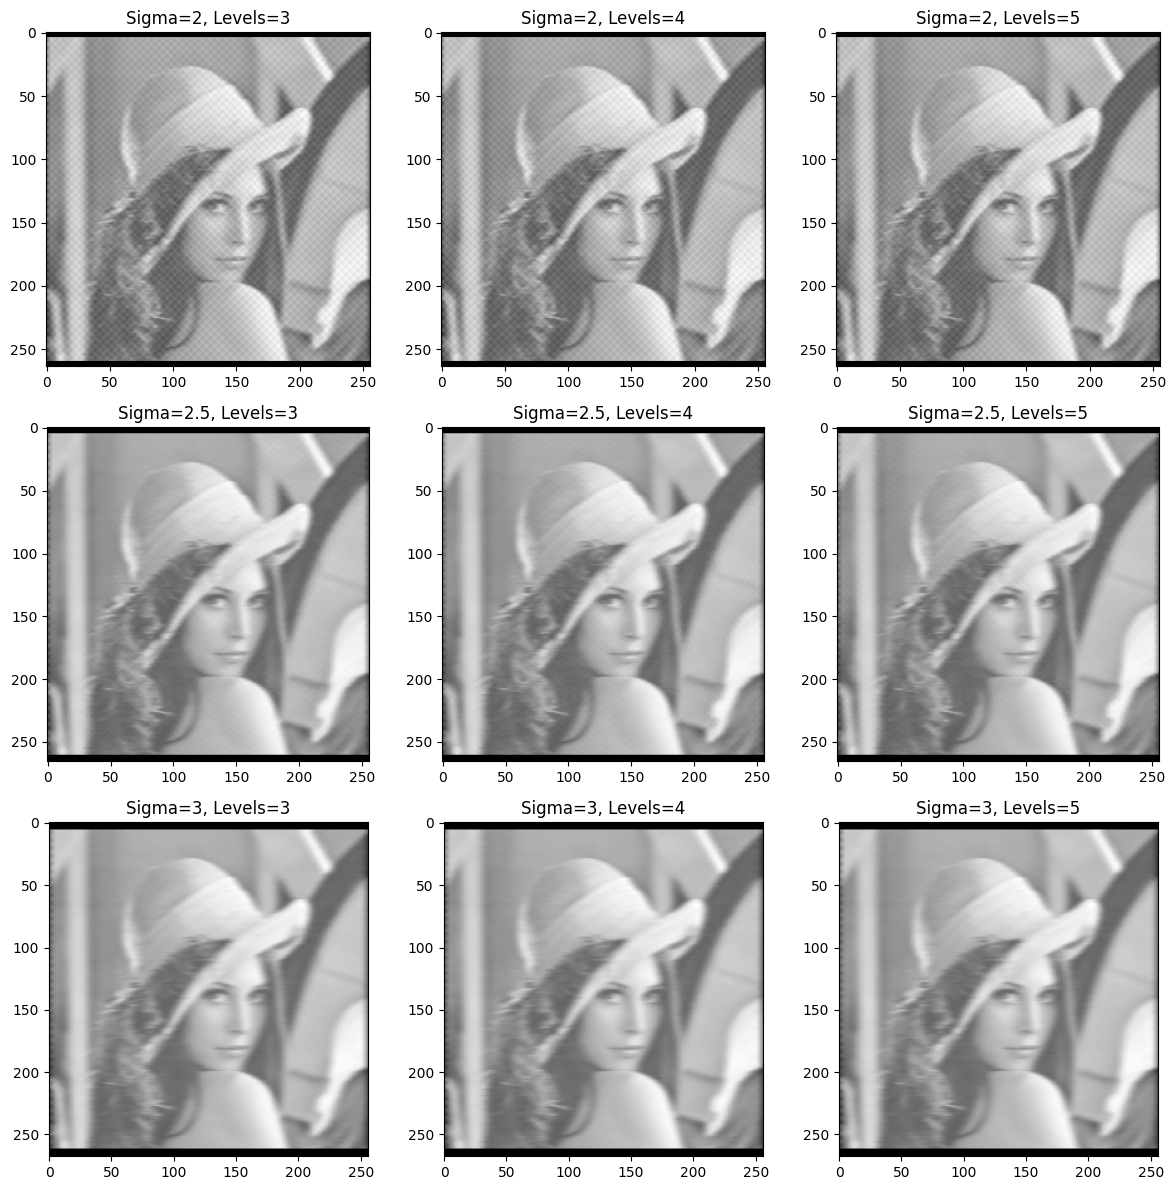

In [ ]:
#Denoising image for different levels of sigma and level

fig, axs = plt.subplots(len(sigma_values), len(level_values), figsize=(12, 12))

for x, sigma in enumerate(sigma_values):
    for y, levels in enumerate(level_values):
        denoised_img = denoise_laplacian_pyramid(noisy_img, levels, sigma)
        axs[x, y].imshow(denoised_img, cmap='gray')
        axs[x, y].set_title(f"Sigma={sigma}, Levels={levels}")

plt.tight_layout()
plt.show()

I used Gaussian filter because it's good at reducing noise while keeping the image clear. I adjusted params: sigma and kernel size to find the right balance between reducing noise and keeping details sharp.
The Gaussian pyramid helps by breaking down the image into different levels, making it easier to clean up noise across the whole picture.